Descompresion de datos

In [ ]:
import missingno as msno
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns

In [ ]:
def descomprimir_zips_en_datos():
    """
    Descomprime todos los archivos ZIP encontrados en el directorio actual
    dentro de una subcarpeta llamada 'datos'.
    """
    carpeta_destino = "datos"

    # Crear la carpeta 'datos' si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
        print(f"Carpeta '{carpeta_destino}' creada.")

    # Obtener una lista de todos los archivos en el directorio actual
    archivos_en_directorio = os.listdir('.')

    # Filtrar solo los archivos .zip
    archivos_zip = [f for f in archivos_en_directorio if f.endswith('.zip')]

    if not archivos_zip:
        print("No se encontraron archivos ZIP en el directorio actual.")
        return

    print(f"Archivos ZIP encontrados: {archivos_zip}")

    for archivo_zip in archivos_zip:
        ruta_completa_zip = os.path.join('.', archivo_zip)
        try:
            with zipfile.ZipFile(ruta_completa_zip, 'r') as zip_ref:
                zip_ref.extractall(os.path.join('.', carpeta_destino))
            print(f"'{archivo_zip}' descomprimido exitosamente en '{carpeta_destino}'.")
        except zipfile.BadZipFile:
            print(f"Error: '{archivo_zip}' no es un archivo ZIP válido o está corrupto.")
        except Exception as e:
            print(f"Ocurrió un error al descomprimir '{archivo_zip}': {e}")

descomprimir_zips_en_datos()

Archivos ZIP encontrados: ['estadisticas_normales_9120.zip', 'Registro_temperaturas-05072025.zip']
'estadisticas_normales_9120.zip' descomprimido exitosamente en 'datos'.
'Registro_temperaturas-05072025.zip' descomprimido exitosamente en 'datos'.


In [ ]:
# Opcional: Para mejorar la visualización en el notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

nombre_excel = "Estadísticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)

if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontró. Asegúrate de que el archivo ZIP se descomprimió correctamente y el archivo .xlsx está en la carpeta 'datos'.")
else:
    print(f"Intentando cargar '{nombre_excel}' sin especificar 'header' inicialmente para inspeccionar...")
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df_raw = pd.read_excel(ruta_completa, header=None)

        print("\n--- Primeras 10 filas del archivo SIN HEADER ESPECIFICADO ---")
        # .to_string() es útil para ver todas las columnas sin truncar en el notebook
        print(df_raw.head(10).to_string())

        print("\n--- Tipo de datos de las columnas SIN HEADER ESPECIFICADO ---")
        df_raw.info()

        # Intentar encontrar la fila que contiene "Estación" y "Valor Medio de"
        # Buscamos en las primeras 10 filas para ser eficientes
        header_row_index = -1
        for i in range(min(10, len(df_raw))):
            # Convertir la fila a string y a minúsculas para una búsqueda insensible a mayúsculas y manejar NaNs
            row_as_str = df_raw.iloc[i].astype(str).str.lower()
            if ('estación' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¡Encabezado detectado en la fila (0-indexada): {header_row_index}!")
            print(f"Las columnas en esa fila son: {df_raw.iloc[header_row_index].tolist()}")
        else:
            print("\nNo se pudo encontrar la fila del encabezado que contiene 'Estación' y 'Valor Medio de' en las primeras 10 filas.")
            print("Por favor, revise la salida anterior para identificar la fila manualmente.")
            print("Si la fila 3 (índice 3) parece correcta, establezca `header_row_index = 3` manualmente y re-ejecute la siguiente celda.")

    except Exception as e:
        print(f"Ocurrió un error al intentar la carga inicial para depuración: {e}")


Intentando cargar 'Estadísticas normales Datos abiertos 1991-2020.xlsx' sin especificar 'header' inicialmente para inspeccionar...

--- Primeras 10 filas del archivo SIN HEADER ESPECIFICADO ---
                                                                                                                                                                                                                                                                                                                                             0                                        1     2     3     4     5     6     7     8     9     10    11    12    13
0                                                                                                                                                                                                                                                                                      Estadísticas Climatológicas Normales - período 1991-2020                      

In [ ]:
df_raw.isnull()  # DataFrame booleano
df_raw.isna().sum() 
df_raw.isna().mean().round(4)*100 

0     0.25
1     0.51
2     0.51
3     0.51
4     0.51
5     0.51
6     0.51
7     0.51
8     0.51
9     0.51
10    0.51
11    0.51
12    0.51
13    0.51
dtype: float64

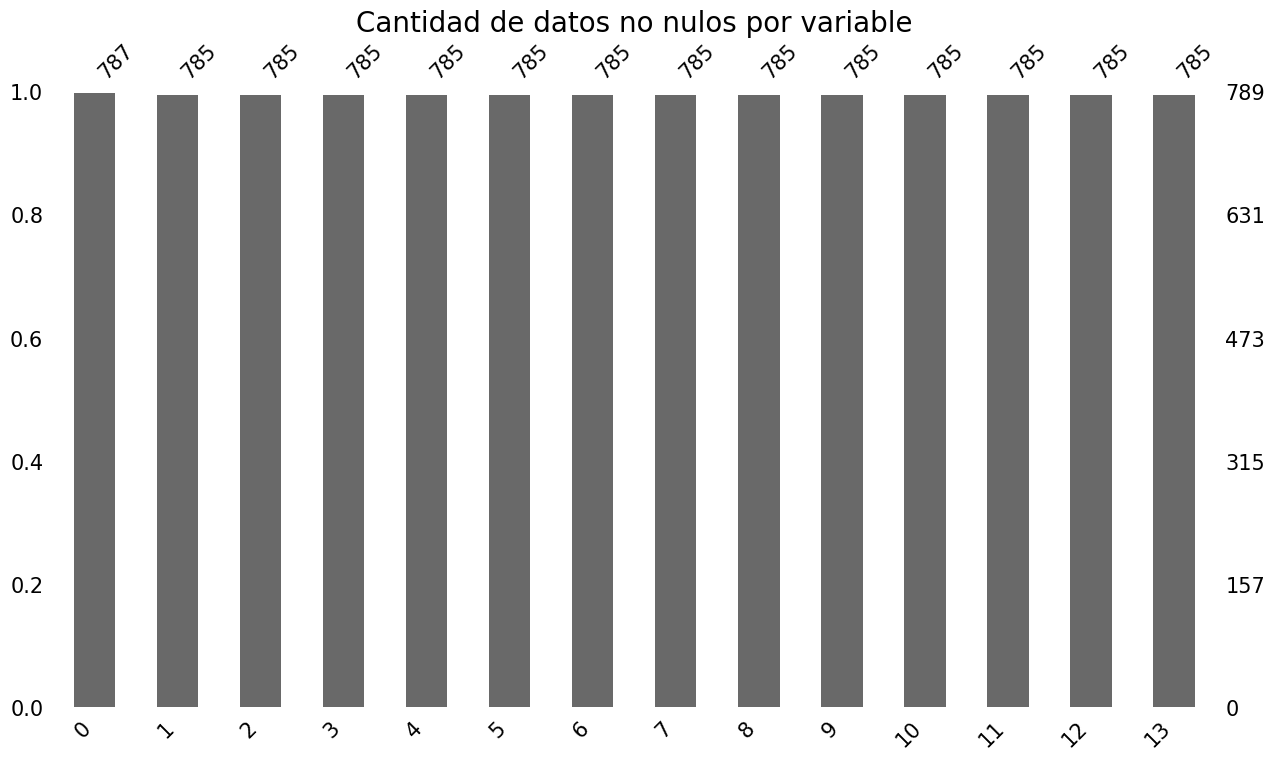

In [ ]:
msno.bar(df_raw, fontsize=15, figsize=(15,8))
plt.title("Cantidad de datos no nulos por variable", fontsize=20)
plt.show()

In [ ]:
if 'header_row_index' not in locals() or header_row_index == -1:
    print("El índice del encabezado no fue detectado automáticamente. Por favor, revísalo en la celda anterior y establécelo manualmente.")
    print("Por ejemplo: header_row_index = 3")
else:
    try:
        # Cargar el Excel usando el header_row_index identificado
        df = pd.read_excel(ruta_completa, header=header_row_index)
        print(f"Archivo '{nombre_excel}' cargado exitosamente con encabezado en la fila {header_row_index}.")

        print("\n--- Primeras 5 filas del DataFrame después de la carga inicial ---")
        print(df.head())
        print("\n--- Nombres de columnas después de la carga inicial ---")
        print(df.columns.tolist())
        print("\n--- Información del DataFrame después de la carga inicial ---")
        df.info()
        
        # 2. Manejo de valores faltantes (S/D) y conversión a numérico
        meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

        columnas_numericas_potenciales = list(meses) + [
            'Temperatura_C', 'Temperatura_Maxima_C', 'Temperatura_Minima_C',
            'Humedad_Relativa_Porcentaje', 'Velocidad_Viento_kmh',
            'Nubosidad_Octavos', 'Precipitacion_mm', 'Frecuencia_Dias_Precipitacion_gt_1mm'
        ]
        columnas_a_procesar = [col for col in columnas_numericas_potenciales if col in df.columns]

        for col in columnas_a_procesar:
            # Reemplazar 'S/D' por NaN y luego convertir a numérico.
            df[col] = df[col].astype(str).replace('S/D', np.nan)
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # 3. Limpieza de la columna 'Estación' (manejo del asterisco)
        df['Estacion_Limpia'] = df['Estación'].astype(str).str.replace('*', '', regex=False).str.strip()
        df['Periodo_Normalizado_Completo'] = ~df['Estación'].astype(str).str.contains('*', regex=False)

        # 4. Eliminar filas completamente vacías al final
        # Usar las columnas clave para determinar si una fila está vacía
        df.dropna(how='all', subset=['Estación', 'Tipo_Variable'] + [m for m in meses if m in df.columns], inplace=True)

        print("\n--- DataFrame después de preprocesamiento inicial (primeras 10 filas) ---")
        print(df.head(10).to_string()) # Usar to_string para ver todo
        print("\n--- Información del DataFrame después de preprocesamiento inicial ---")
        df.info()
        print("\n--- Valores nulos por columna después de preprocesamiento inicial ---")
        print(df.isnull().sum())

    except Exception as e:
        print(f"Ocurrió un error durante el preprocesamiento inicial: {e}")

Archivo 'Estadísticas normales Datos abiertos 1991-2020.xlsx' cargado exitosamente con encabezado en la fila 4.

--- Primeras 5 filas del DataFrame después de la carga inicial ---
                 Estación                           Valor Medio de   Ene   Feb   Mar   Abr   May   Jun   Jul   Ago   Sep   Oct   Nov   Dic
0  LA QUIACA OBSERVATORIO                         Temperatura (°C)  13.2    13  12.8  11.3   7.3   4.8   4.5     7    10  12.4  13.4  13.9
1  LA QUIACA OBSERVATORIO                  Temperatura máxima (°C)  20.6  20.4  20.6  20.3  17.8  16.3  16.1    18    20  21.7  22.5  22.2
2  LA QUIACA OBSERVATORIO                  Temperatura mínima (°C)   7.7   7.6   6.6   3.1  -2.5  -5.7  -6.2    -4  -0.4   3.3   5.5   7.3
3  LA QUIACA OBSERVATORIO                     Humedad relativa (%)  62.6  63.2  60.3    46  32.6  27.4  25.7  26.7  32.1  42.4  48.6  55.8
4  LA QUIACA OBSERVATORIO  Velocidad del Viento (km/h) (2011-2020)   6.5   6.8   6.7   5.5   4.8   5.5   5.9   6.7   7.9   7.

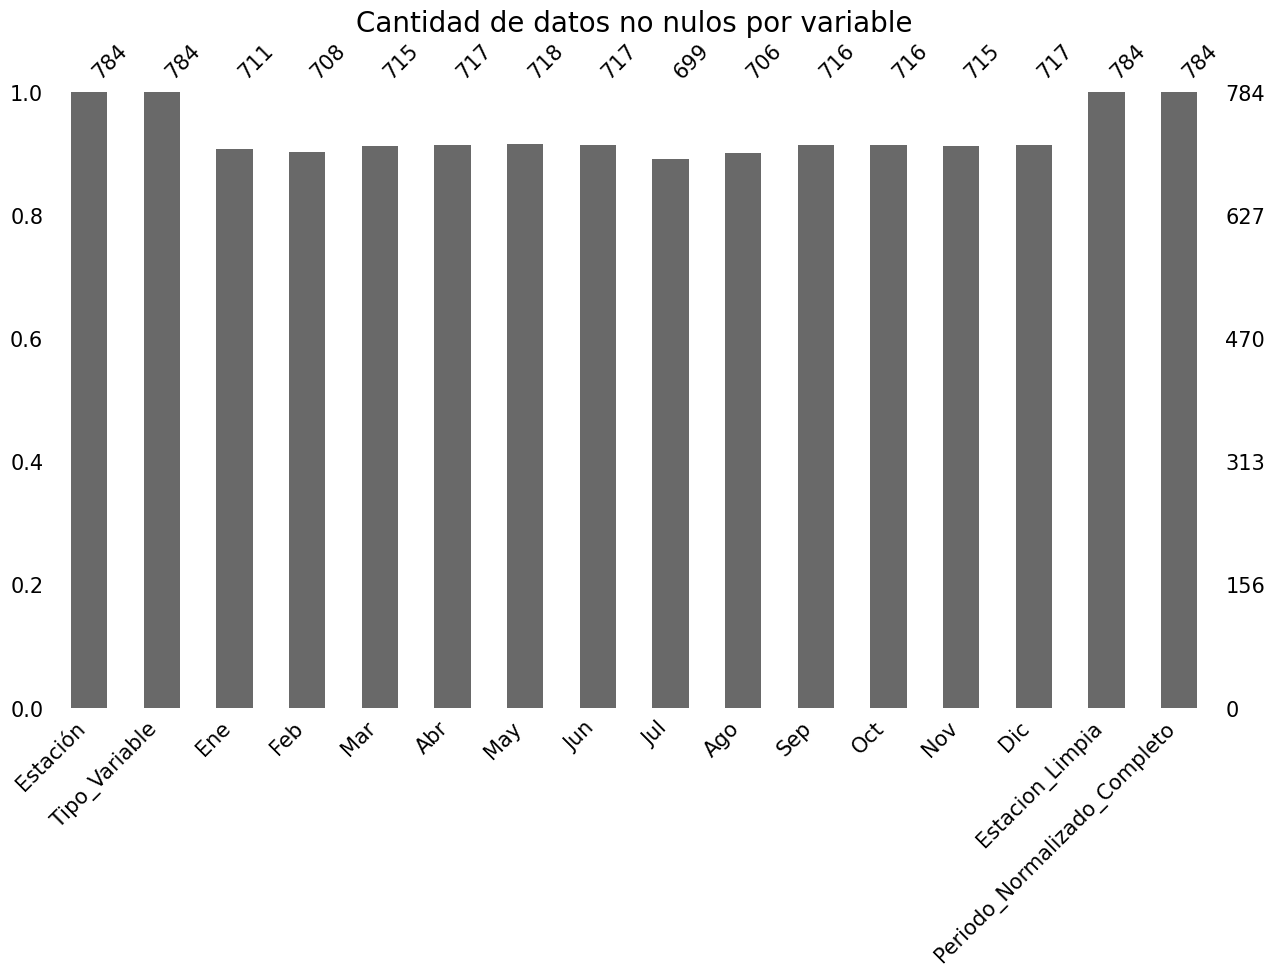

In [27]:
df.isnull()  # DataFrame booleano
df.isna().sum() 
df.isna().mean().round(4)*100 
msno.bar(df, fontsize=15, figsize=(15,8))
plt.title("Cantidad de datos no nulos por variable", fontsize=20)
plt.show()

<Axes: >

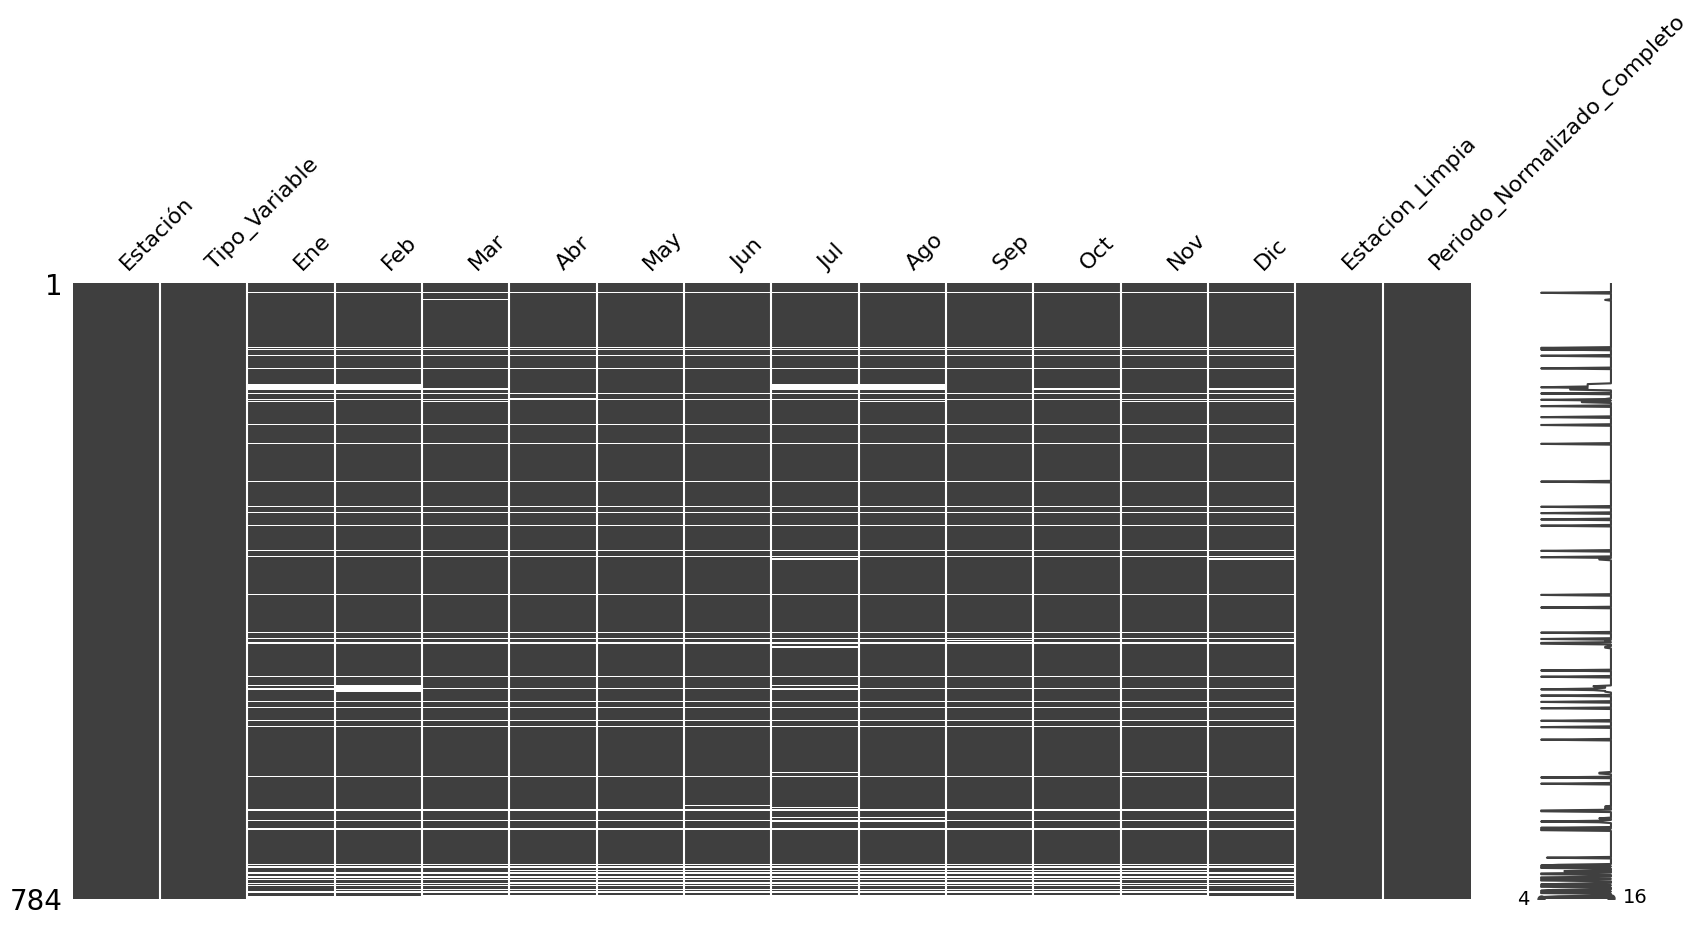

In [28]:
msno.matrix(df, figsize=(20,8))

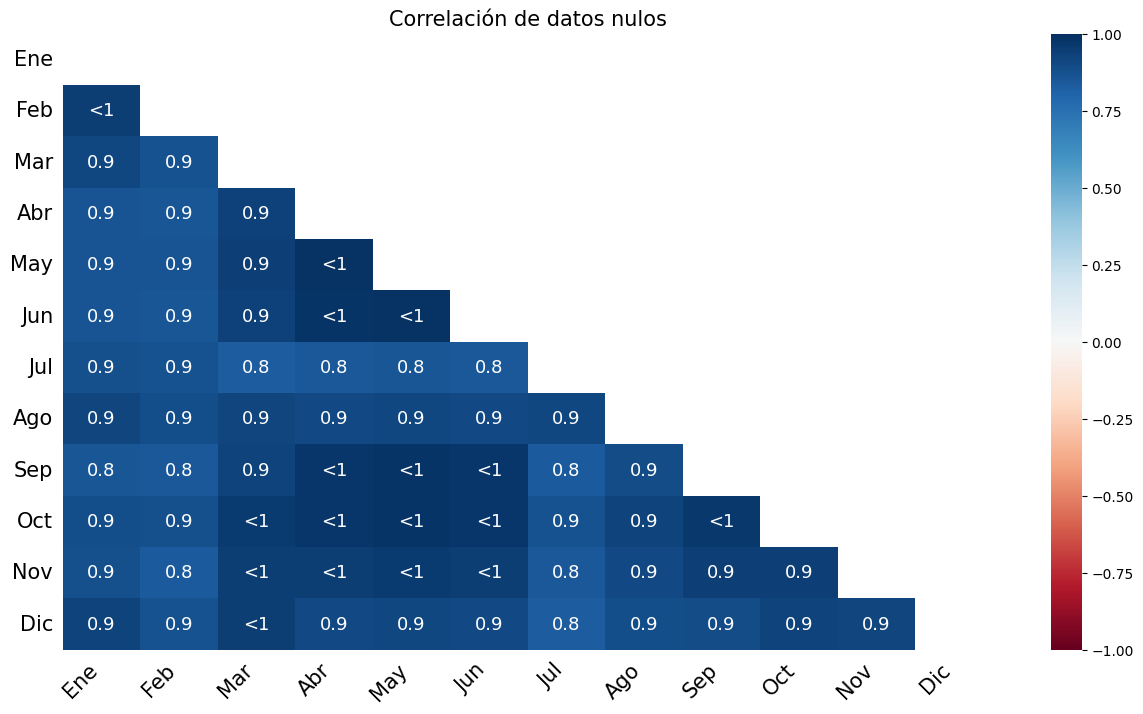

In [31]:
msno.heatmap(df, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

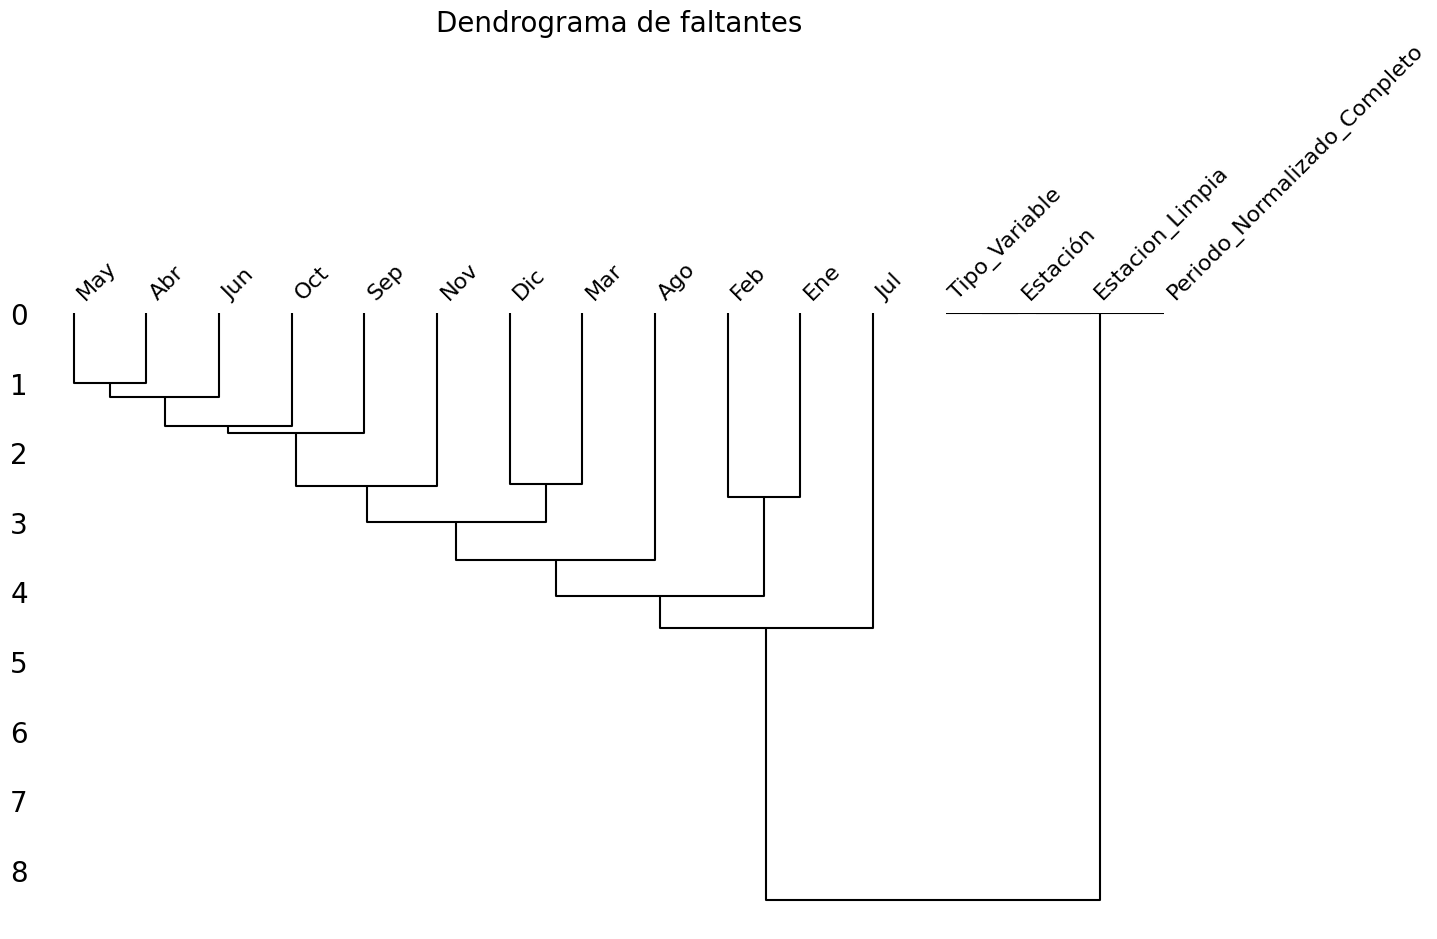

In [32]:
msno.dendrogram(df, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

In [ ]:
# Creamos una función para calcular el porcentaje de nulos en una columna, agrupando por una o más columnas
def nulos_por_grupo(df, grupo_cols, target_col):
    agrupar_nulos = (
        df.groupby(grupo_cols, observed=True)[target_col]
        .apply(lambda x: x.isnull().mean() * 100)
        .reset_index(name=f'porcentaje_nulos_{target_col}')
    )
    return agrupar_nulos

nulos_May_por_Abr = nulos_por_grupo(df, 'May', 'Abr')
nulos_Ene_por_Feb = nulos_por_grupo(df, 'Ene', 'Feb')


# Resultados:
print("Nulos en 'May' por Abr:\n", nulos_May_por_Abr, "\n")
print("Nulos en 'Ene' por Feb:\n", nulos_Ene_por_Feb, "\n")

                 Estación                                      Tipo_Variable    Ene   Feb   Mar   Abr   May   Jun   Jul   Ago   Sep   Oct   Nov   Dic         Estacion_Limpia  Periodo_Normalizado_Completo
0  LA QUIACA OBSERVATORIO                                   Temperatura (°C)   13.2  13.0  12.8  11.3   7.3   4.8   4.5   7.0  10.0  12.4  13.4  13.9  LA QUIACA OBSERVATORIO                          True
1  LA QUIACA OBSERVATORIO                            Temperatura máxima (°C)   20.6  20.4  20.6  20.3  17.8  16.3  16.1  18.0  20.0  21.7  22.5  22.2  LA QUIACA OBSERVATORIO                          True
2  LA QUIACA OBSERVATORIO                            Temperatura mínima (°C)    7.7   7.6   6.6   3.1  -2.5  -5.7  -6.2  -4.0  -0.4   3.3   5.5   7.3  LA QUIACA OBSERVATORIO                          True
3  LA QUIACA OBSERVATORIO                               Humedad relativa (%)   62.6  63.2  60.3  46.0  32.6  27.4  25.7  26.7  32.1  42.4  48.6  55.8  LA QUIACA OBSERVATORIO           

In [4]:
# Asegurarse de que df exista y haya sido preprocesado
if 'df' in locals():
    # --- Reestructuración a formato "long" (tidy data) ---

    meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

    # Identificar las columnas a "derretir" (los meses)
    # Asegúrate de que 'Tipo_Variable' exista, ya que es fundamental para el melting
    id_vars = ['Estación', 'Tipo_Variable', 'Estacion_Limpia', 'Periodo_Normalizado_Completo']
    # Filtrar solo las columnas de meses que realmente existen en df.columns
    value_vars = [m for m in meses if m in df.columns]

    if not value_vars:
        print("Advertencia: No se encontraron columnas de meses para reestructurar. Verifique los nombres de las columnas en el DataFrame 'df'.")
        df_melted = None # Asegurar que df_melted no se cree si no hay meses
    else:
        try:
            df_melted = df.melt(id_vars=id_vars,
                                value_vars=value_vars,
                                var_name='Mes',
                                value_name='Valor_Mensual')

            print("\n--- DataFrame reestructurado en formato 'long' (melted) ---")
            print(df_melted.head(20).to_string()) # Mostrar más filas para ver la nueva estructura
            print("\nInformación del DataFrame melted:")
            df_melted.info()
            print("\nValores nulos en el DataFrame melted:")
            print(df_melted.isnull().sum())

        except Exception as e:
            print(f"Ocurrió un error al reestructurar el DataFrame: {e}")
            df_melted = None
else:
    print("El DataFrame 'df' no se creó en la celda anterior. No se puede reestructurar.")
    df_melted = None # Asegurar que df_melted no se defina


--- DataFrame reestructurado en formato 'long' (melted) ---
                  Estación                                           Tipo_Variable         Estacion_Limpia  Periodo_Normalizado_Completo  Mes  Valor_Mensual
0   LA QUIACA OBSERVATORIO                                        Temperatura (°C)  LA QUIACA OBSERVATORIO                          True  Ene           13.2
1   LA QUIACA OBSERVATORIO                                 Temperatura máxima (°C)  LA QUIACA OBSERVATORIO                          True  Ene           20.6
2   LA QUIACA OBSERVATORIO                                 Temperatura mínima (°C)  LA QUIACA OBSERVATORIO                          True  Ene            7.7
3   LA QUIACA OBSERVATORIO                                    Humedad relativa (%)  LA QUIACA OBSERVATORIO                          True  Ene           62.6
4   LA QUIACA OBSERVATORIO                 Velocidad del Viento (km/h) (2011-2020)  LA QUIACA OBSERVATORIO                          True  Ene            6

In [40]:
if 'df_melted' in locals() and df_melted is not None:
    # Asegurar el orden de los meses para el pivot final
    orden_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    if 'Mes' in df_melted.columns:
        df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=orden_meses, ordered=True)
    else:
        print("La columna 'Mes' no se encuentra en df_melted. No se puede ordenar por meses.")

    try:
        # Primero, asegúrate de que los datos estén ordenados por estación, tipo de variable y mes
        df_sorted = df_melted.sort_values(by=['Estacion_Limpia', 'Tipo_Variable', 'Mes'])

        # Agrupar por estación y tipo de variable, y recolectar los 12 valores mensuales en una lista.
        # RENOMBRAMOS explícitamente la columna resultante a 'Vector_Mensual_Valores'.
        df_vectorized = df_sorted.groupby(['Estacion_Limpia', 'Tipo_Variable'])['Valor_Mensual'].apply(list).reset_index(name='Vector_Mensual_Valores')
        
        # Ahora pivotar este df_vectorized para que 'Tipo_Variable' se convierta en columnas
        # y los valores sean las listas de 12 meses.
        df_final_vector_pivot = df_vectorized.pivot_table(
            index='Estacion_Limpia',
            columns='Tipo_Variable',
            values='Vector_Mensual_Valores', # Ahora esta columna sí existe
            aggfunc='first'
        ).reset_index()

        # Opcional: fusionar Periodo_Normalizado_Completo si es necesario, ya que se perdió en el pivot
        df_periodo = df_melted[['Estacion_Limpia', 'Periodo_Normalizado_Completo']].drop_duplicates()
        df_final_vector_pivot = df_final_vector_pivot.merge(df_periodo, on='Estacion_Limpia', how='left')
        nuevos_nombres = {
            'Valor Medio de': 'Tipo_Variable',
            'Temperatura (°C)': 'Temperatura_C',
            'Temperatura máxima (°C)': 'Temperatura_Maxima_C',
            'Temperatura mínima (°C)': 'Temperatura_Minima_C',
            'Humedad relativa (%)': 'Humedad_Relativa_Porcentaje',
            'Velocidad del Viento (km/h) (2011-2020)': 'Velocidad_Viento_kmh',
            'Nubosidad total (octavos)': 'Nubosidad_Octavos',
            'Precipitación (mm)': 'Precipitacion_mm',
            'Frecuencia de días con Precipitación superior a 1.0 mm': 'Frecuencia_Dias_Precipitacion_gt_1mm'
        }
        # Solo renombra si la columna existe en el DataFrame
        df_final_vector_pivot.rename(columns={k: v for k, v in nuevos_nombres.items() if k in df_final_vector_pivot.columns}, inplace=True)
        print("\n--- Columnas renombradas ---")
        print(df_final_vector_pivot.columns.tolist())
        print(df_final_vector_pivot.head(10).to_string())  # Mostrar más filas para ver la nueva estructura

    except Exception as e:
        print(f"Ocurrió un error al realizar el pivotaje final para obtener vectores: {e}")
else:
    print("El DataFrame 'df_melted' no está disponible para el pivotaje final.")


--- Columnas renombradas ---
['Estacion_Limpia', 'Frecuencia_Dias_Precipitacion_gt_1mm', 'Humedad_Relativa_Porcentaje', 'Nubosidad_Octavos', 'Precipitacion_mm', 'Temperatura_C', 'Temperatura_Maxima_C', 'Temperatura_Minima_C', 'Velocidad_Viento_kmh', 'Periodo_Normalizado_Completo']
            Estacion_Limpia                              Frecuencia_Dias_Precipitacion_gt_1mm                                               Humedad_Relativa_Porcentaje                                             Nubosidad_Octavos                                                                 Precipitacion_mm                                                                     Temperatura_C                                                           Temperatura_Maxima_C                                                                Temperatura_Minima_C                                                      Velocidad_Viento_kmh  Periodo_Normalizado_Completo
0           AEROPARQUE AERO      [6.7, 6.0, 5.9, 6.6, 5.0

In [42]:
#==============================================================================
# Parte 1: Convertir las columnas de texto en listas numéricas
#==============================================================================
# Función para convertir un string como '[1, 2, nan]' en una lista numérica [1.0, 2.0, np.nan]
def safe_literal_eval(s):
    # Asegurarse de que el valor sea un string antes de procesar
    if not isinstance(s, str):
        return s
    
    # Reemplazar 'nan' con 'None', que es un literal válido en Python, para que ast.literal_eval funcione
    s_safe = s.replace('nan', 'None')
    
    try:
        # Convertir el string a una lista
        evaluated_list = ast.literal_eval(s_safe)
        # Reemplazar los 'None' con el valor numérico NaN de NumPy para los cálculos
        return [np.nan if x is None else x for x in evaluated_list]
    except (ValueError, SyntaxError):
        # Si la conversión falla, devolver el valor original
        return s

# Identificar las columnas que no son 'Estacion_Limpia' o de metadatos para aplicar la conversión
# Asume que las columnas a convertir contienen '[' en sus valores
columnas_a_convertir = [col for col in df_final_vector_pivot.columns if df_final_vector_pivot[col].astype(str).str.contains('\[', na=False).any()]

for col in columnas_a_convertir:
    df_final_vector_pivot[col] = df_final_vector_pivot[col].apply(safe_literal_eval)

print("✅ Conversión de strings a listas completada.")


#==============================================================================
# Parte 2: Análisis de Valores Nulos dentro de los Vectores
#==============================================================================
# Crear un nuevo DataFrame para almacenar el conteo de NaNs
df_final_vector_pivot_nan_counts = df_final_vector_pivot[['Estacion_Limpia']].copy()

# Identificar las columnas que ahora contienen listas
variable_cols = [col for col in df_final_vector_pivot.columns if isinstance(df_final_vector_pivot[col].iloc[0], list)]

# Contar los NaNs en cada lista
for col in variable_cols:
    df_final_vector_pivot_nan_counts[col] = df_final_vector_pivot[col].apply(lambda x: sum(pd.isna(val) for val in x) if isinstance(x, list) else 0)

# Guardar los resultados en un archivo CSV
df_final_vector_pivot_nan_counts.to_csv("conteo_nulos_por_vector.csv", index=False)
print("📊 Análisis de nulos guardado en 'conteo_nulos_por_vector.csv'")


#==============================================================================
# Parte 3: Cálculo de Estadísticas Anuales Descriptivas
#==============================================================================
# Crear un DataFrame para las estadísticas, usando Estacion_Limpia como índice
df_final_vector_pivot_stats = pd.DataFrame(index=df_final_vector_pivot['Estacion_Limpia'])
orden_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Función para obtener el nombre del mes del valor máximo o mínimo
def get_month_name(vector, func_type):
    if not isinstance(vector, list): return 'N/A'
    s = pd.Series(vector)
    if s.isnull().all():
        return 'N/A'
    if func_type == 'max':
        return orden_meses[s.idxmax()]
    if func_type == 'min':
        return orden_meses[s.idxmin()]
    return 'N/A'

# Iterar sobre cada columna de variable para calcular las estadísticas
for col in variable_cols:
    # Media Anual
    df_final_vector_pivot_stats[f'{col} - Media Anual'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: np.nanmean(x) if isinstance(x, list) else np.nan)
    
    # Suma Anual (útil para precipitación y frecuencia)
    if 'Precipitación' in col or 'Frecuencia' in col:
         df_final_vector_pivot_stats[f'{col} - Suma Anual'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: np.nansum(x) if isinstance(x, list) else np.nan)

    # Máximo y Mínimo Anual
    df_final_vector_pivot_stats[f'{col} - Máximo Anual'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: np.nanmax(x) if isinstance(x, list) and not all(pd.isna(v) for v in x) else np.nan)
    df_final_vector_pivot_stats[f'{col} - Mes del Máximo'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: get_month_name(x, 'max'))
    
    df_final_vector_pivot_stats[f'{col} - Mínimo Anual'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: np.nanmin(x) if isinstance(x, list) and not all(pd.isna(v) for v in x) else np.nan)
    df_final_vector_pivot_stats[f'{col} - Mes del Mínimo'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: get_month_name(x, 'min'))

# Redondear los resultados numéricos a dos decimales
df_final_vector_pivot_stats = df_final_vector_pivot_stats.round(2)

# Guardar las estadísticas en un archivo CSV
df_final_vector_pivot_stats.to_csv("estadisticas_anuales_por_estacion.csv")
print("📈 Estadísticas anuales guardadas en 'estadisticas_anuales_por_estacion.csv'")

<>:24: SyntaxWarning: invalid escape sequence '\['
<>:24: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_49882/3054403479.py:24: SyntaxWarning: invalid escape sequence '\['
  columnas_a_convertir = [col for col in df_final_vector_pivot.columns if df_final_vector_pivot[col].astype(str).str.contains('\[', na=False).any()]
/tmp/ipykernel_49882/3054403479.py:72: RuntimeWarning: Mean of empty slice
  df_final_vector_pivot_stats[f'{col} - Media Anual'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: np.nanmean(x) if isinstance(x, list) else np.nan)
/tmp/ipykernel_49882/3054403479.py:72: RuntimeWarning: Mean of empty slice
  df_final_vector_pivot_stats[f'{col} - Media Anual'] = df_final_vector_pivot.set_index('Estacion_Limpia')[col].apply(lambda x: np.nanmean(x) if isinstance(x, list) else np.nan)
/tmp/ipykernel_49882/3054403479.py:72: RuntimeWarning: Mean of empty slice
  df_final_vector_pivot_stats[f'{col} - Media Anual'] = df_final_vector_pivot.set_ind

✅ Conversión de strings a listas completada.
📊 Análisis de nulos guardado en 'conteo_nulos_por_vector.csv'
📈 Estadísticas anuales guardadas en 'estadisticas_anuales_por_estacion.csv'


✅ Se generarán gráficos para 98 estaciones.


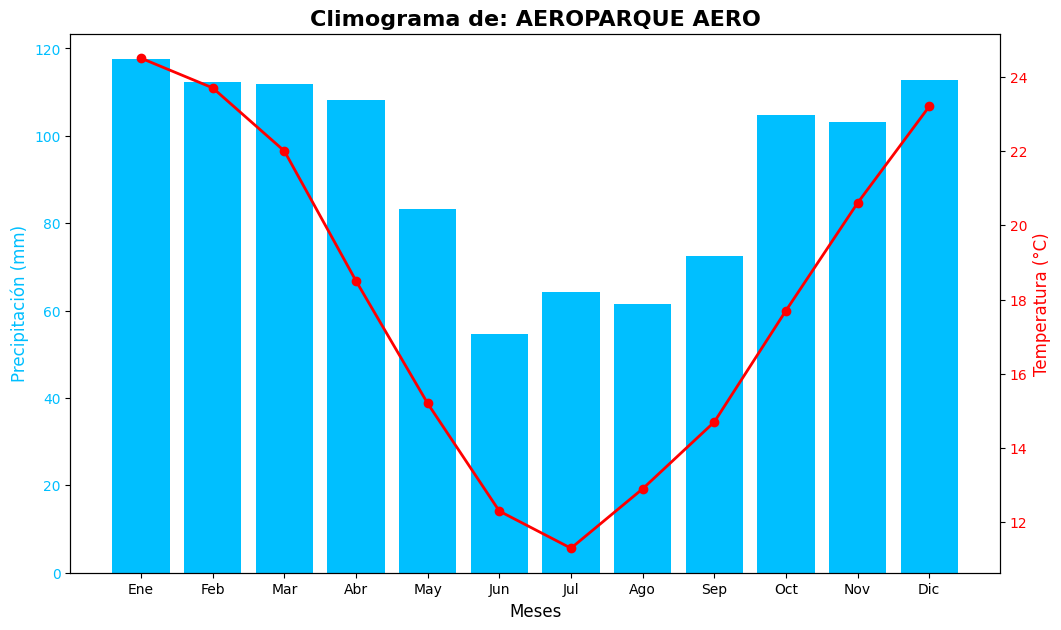

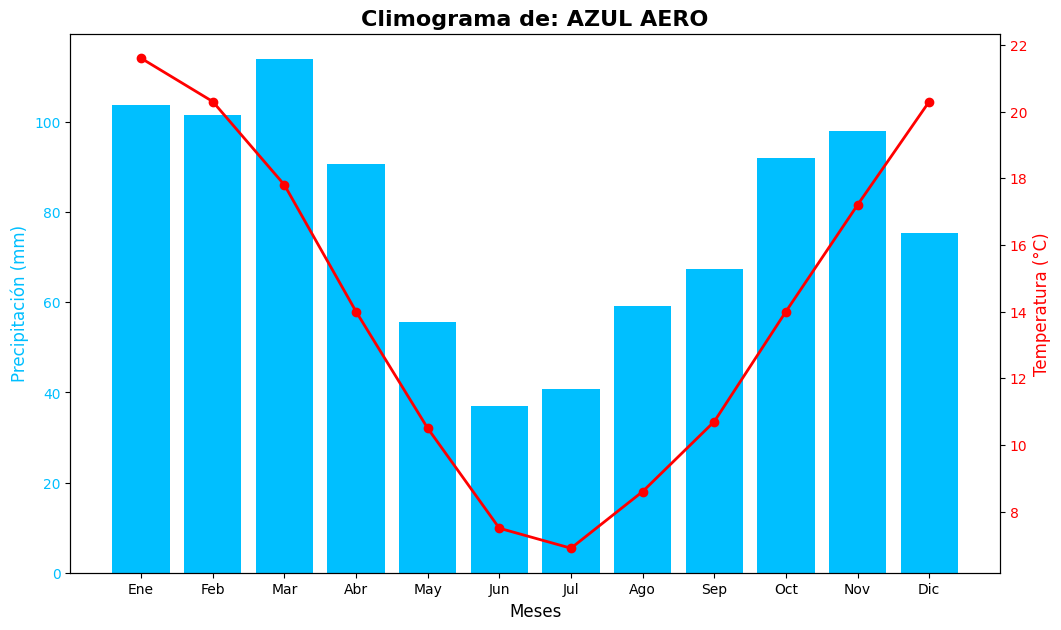

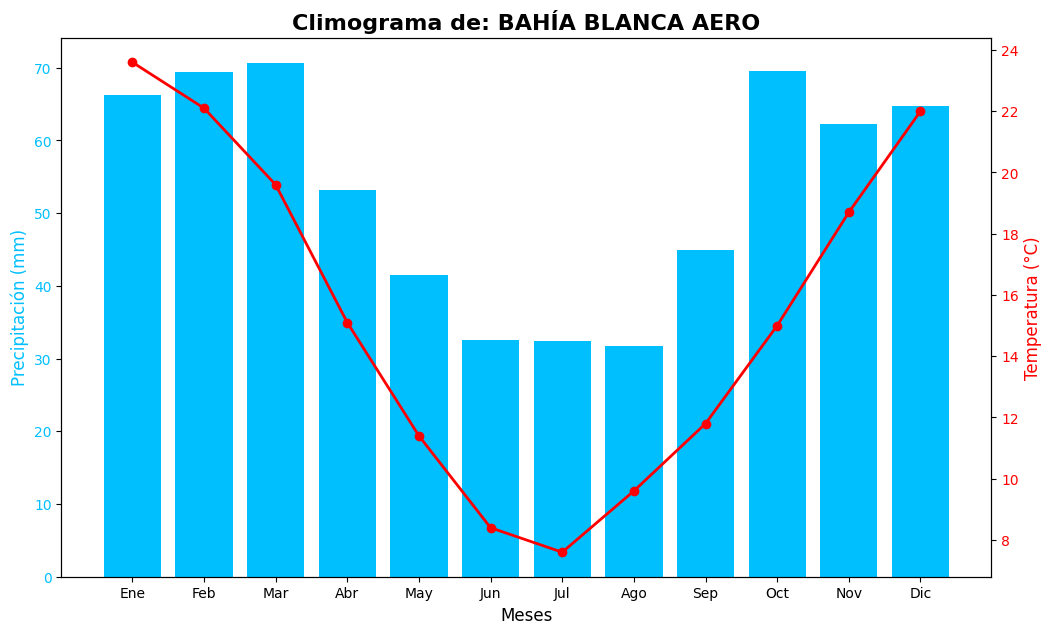

💾 Proceso completado. Los gráficos se han guardado en la carpeta 'climogramas'.


In [ ]:
# --- 1. Configuración ---
# Directorio donde se guardarán los gráficos
directorio_salida = 'climogramas'
# Crea el directorio si no existe, sin dar error si ya existe.
os.makedirs(directorio_salida, exist_ok=True)

# Lista de meses para el eje X
meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Obtiene una lista única de todas las estaciones en tu DataFrame
estaciones_a_graficar = df_final_vector_pivot['Estacion_Limpia'].unique()
print(f"✅ Se generarán gráficos para {len(estaciones_a_graficar[:3])} estaciones.")

# --- 2. Bucle para generar y guardar los gráficos ---
for estacion in estaciones_a_graficar[:3]:
    # Filtra los datos para la estación actual del bucle
    estacion_data = df_final_vector_pivot[df_final_vector_pivot['Estacion_Limpia'] == estacion].iloc[0]

    # Extrae los datos usando los NUEVOS nombres de columna
    temperaturas = estacion_data['Temperatura_C']
    precipitaciones = estacion_data['Precipitacion_mm']

    # --- Creación del gráfico (igual que antes) ---
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Barras de precipitación
    ax1.bar(meses, precipitaciones, color='deepskyblue', label='Precipitación (mm)')
    ax1.set_xlabel('Meses', fontsize=12)
    ax1.set_ylabel('Precipitación (mm)', color='deepskyblue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='deepskyblue')

    # Línea de temperatura en el segundo eje Y
    ax2 = ax1.twinx()
    ax2.plot(meses, temperaturas, color='red', marker='o', linestyle='-', linewidth=2, label='Temperatura (°C)')
    ax2.set_ylabel('Temperatura (°C)', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Título dinámico para cada gráfico
    plt.title(f'Climograma de: {estacion}', fontsize=16, fontweight='bold')
    
    # --- 3. Guardar el gráfico en un archivo ---
    # Se crea un nombre de archivo único para cada estación
    nombre_archivo = f"Climograma_{estacion.replace(' ', '_')}.png"
    ruta_completa = os.path.join(directorio_salida, nombre_archivo)
    
    # Guarda la figura en la ruta especificada
    plt.show(ruta_completa)
    
    # Cierra la figura para liberar memoria antes de pasar a la siguiente iteración
    plt.close(fig)

✅ Gráfico guardado como 'mapa_calor_nulos.png'


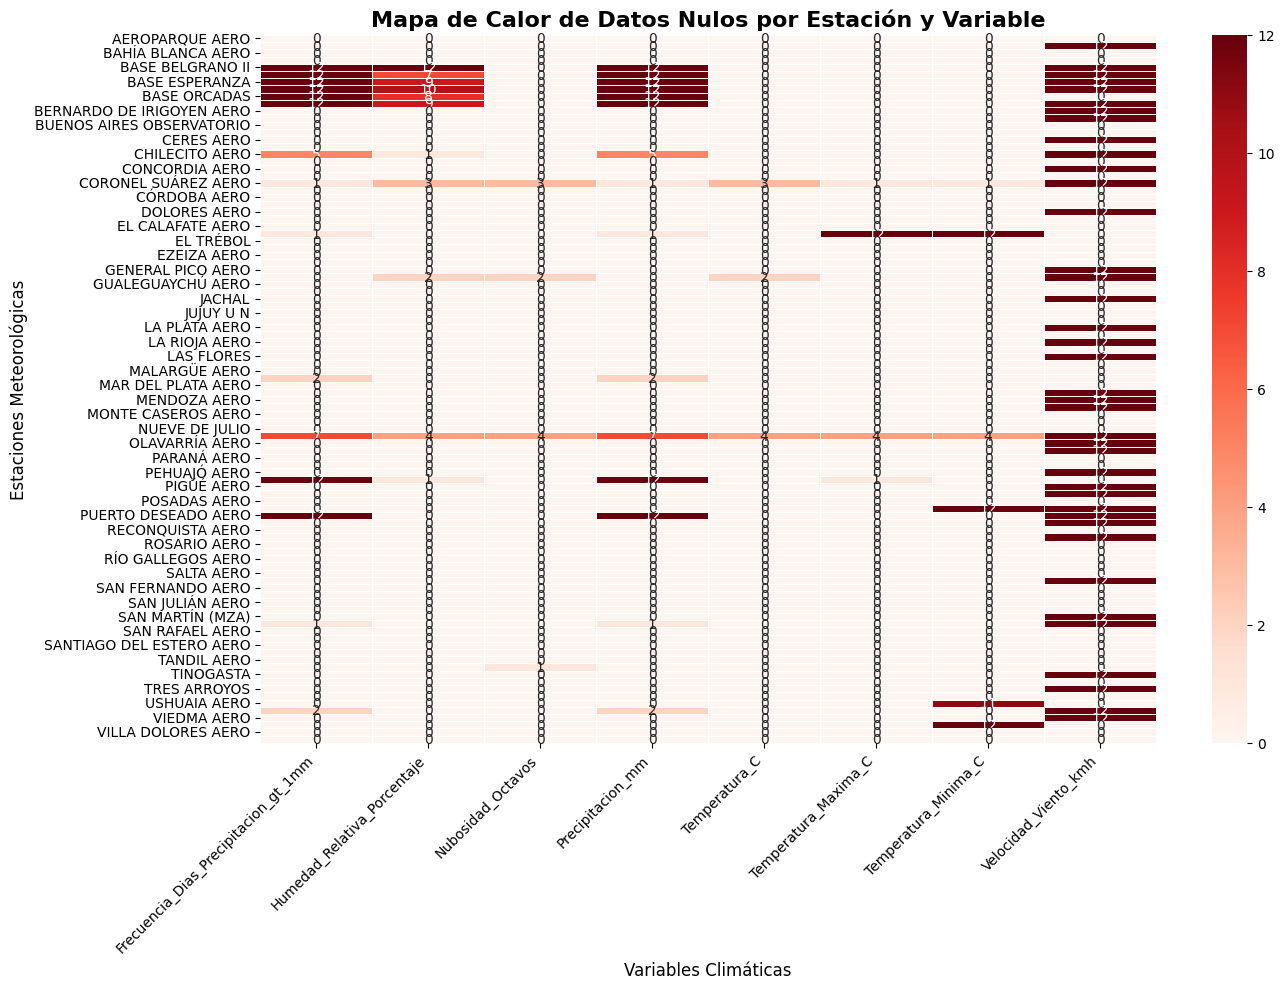

In [46]:

# --- 1. Cargar los datos ---
# Asegúrate de que el archivo 'conteo_nulos_por_vector.csv' esté en el mismo directorio
try:
    df_nulos = pd.read_csv('conteo_nulos_por_vector.csv')
except FileNotFoundError:
    print("Error: No se encontró el archivo 'conteo_nulos_por_vector.csv'.")
    # Salir del script si no se encuentra el archivo
    exit()

# --- 2. Preparar los datos para el gráfico ---
# Para que el mapa de calor funcione correctamente,
# las estaciones deben ser el índice del DataFrame.
df_nulos.set_index('Estacion_Limpia', inplace=True)

# Elimina las comillas que puedan haber quedado en los nombres de las estaciones
df_nulos.index = df_nulos.index.str.replace('"', '')

# --- 3. Generar el Mapa de Calor ---
plt.figure(figsize=(14, 10)) # Ajusta el tamaño para que sea legible

heatmap = sns.heatmap(
    df_nulos, 
    annot=True,     # Muestra los números (el conteo de nulos) en cada celda
    cmap='Reds',    # Paleta de colores: un rojo más intenso significa más nulos
    fmt='d',        # Formato de número entero para las anotaciones
    linewidths=.5   # Líneas delgadas para separar las celdas
)

# --- 4. Personalizar y guardar el gráfico ---
plt.title('Mapa de Calor de Datos Nulos por Estación y Variable', fontsize=16, fontweight='bold')
plt.xlabel('Variables Climáticas', fontsize=12)
plt.ylabel('Estaciones Meteorológicas', fontsize=12)

# Rota las etiquetas del eje X para que no se superpongan
plt.xticks(rotation=45, ha='right')

# Ajusta el layout para que todo quepa en la imagen
plt.tight_layout()

# Guarda el gráfico en un archivo
nombre_archivo_salida = 'mapa_calor_nulos.png'
plt.savefig(nombre_archivo_salida, dpi=120)

print(f"✅ Gráfico guardado como '{nombre_archivo_salida}'")

# Muestra el gráfico
plt.show()

In [ ]:
# --- 1. Aplanar los datos ---
# Crea un diccionario para almacenar las series de datos aplanadas
datos_planos = {}
# Identifica las columnas que contienen listas de valores
columnas_metricas = df_final_vector_pivot.select_dtypes(include='object').columns.drop('Estacion_Limpia')

for metrica in columnas_metricas:
    # 'explode' convierte cada elemento de una lista en su propia fila.
    # Esto une todos los valores mensuales de todas las estaciones en una sola columna.
    serie_aplanada = df_final_vector_pivot[metrica].explode().dropna().astype(float)
    datos_planos[metrica] = serie_aplanada

print("✅ Datos aplanados correctamente.")

# --- 2. Calcular las estadísticas ---
resultados_estadisticos = []

for nombre, datos in datos_planos.items():
    # Calcula la moda, manejando el caso de que no haya una única.
    moda = datos.mode()
    moda_valor = moda.iloc[0] if not moda.empty else np.nan
    
    # Crea un diccionario con todas las estadísticas
    stats = {
        'Metrica': nombre,
        # Tendencia Central
        'Media': datos.mean(),
        'Mediana': datos.median(),
        'Moda': moda_valor,
        # Dispersión
        'Desv_Estandar': datos.std(),
        'Varianza': datos.var(),
        'Rango': datos.max() - datos.min(),
        'Rango_Intercuartil': datos.quantile(0.75) - datos.quantile(0.25),
        # Forma (Momentos de 3er y 4to orden)
        'Asimetria': datos.skew(),
        'Curtosis': datos.kurt()
    }
    resultados_estadisticos.append(stats)

# --- 3. Crear y mostrar el DataFrame de estadísticas ---
df_estadisticas = pd.DataFrame(resultados_estadisticos).set_index('Metrica')

print("\n--- Tabla de Estadísticas Anuales Generales ---")
# Muestra la tabla de estadísticas redondeada a 2 decimales
display(df_estadisticas.round(2))

✅ Datos aplanados correctamente.

--- Tabla de Estadísticas Anuales Generales ---


,Media,Mediana,Moda,Desv_Estandar,Varianza,Rango,Rango_Intercuartil,Asimetria,Curtosis
Metrica,,,,,,,,,
Frecuencia_Dias_Precipitacion_gt_1mm,5.10,5.2,6.5,2.54,6.43,13.8,3.90,0.19,-0.19
Humedad_Relativa_Porcentaje,68.01,70.1,71.1,11.03,121.61,64.5,15.08,-0.72,0.12
Nubosidad_Octavos,3.84,3.7,3.7,0.89,0.79,6.2,0.90,1.11,2.38
Precipitacion_mm,68.23,58.9,24.4,51.67,2670.26,277.9,83.20,0.66,-0.26
Temperatura_C,14.83,15.7,21.8,8.18,66.89,49.2,10.90,-1.09,1.77
Temperatura_Maxima_C,21.22,22.4,27.9,8.94,79.90,53.0,10.88,-1.27,2.04
Temperatura_Minima_C,9.10,9.9,4.9,7.78,60.51,47.5,10.60,-0.98,1.69
Velocidad_Viento_kmh,13.01,11.8,10.4,5.55,30.85,32.6,6.70,0.96,0.97



--- Histogramas de Distribución por Métrica ---


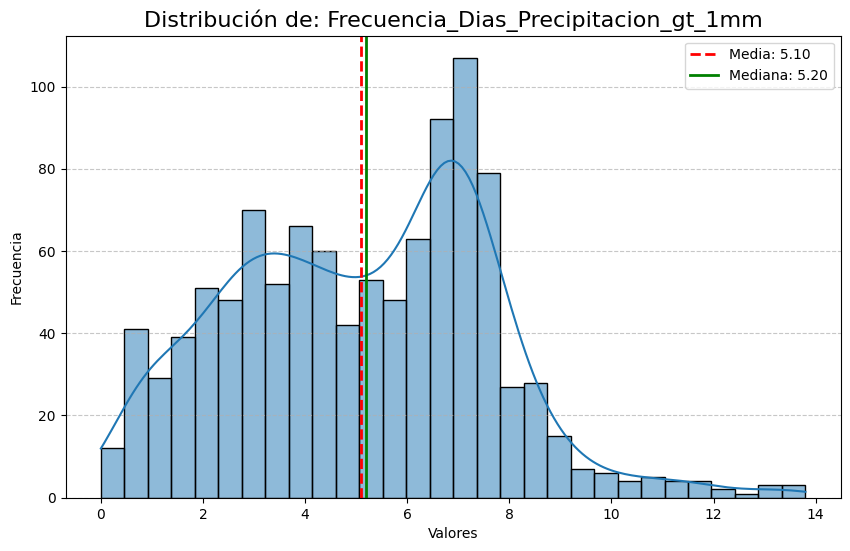

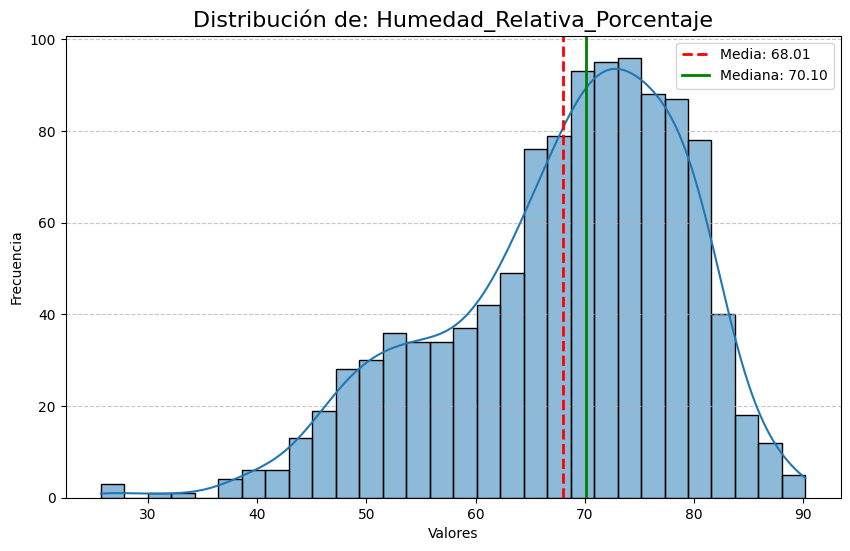

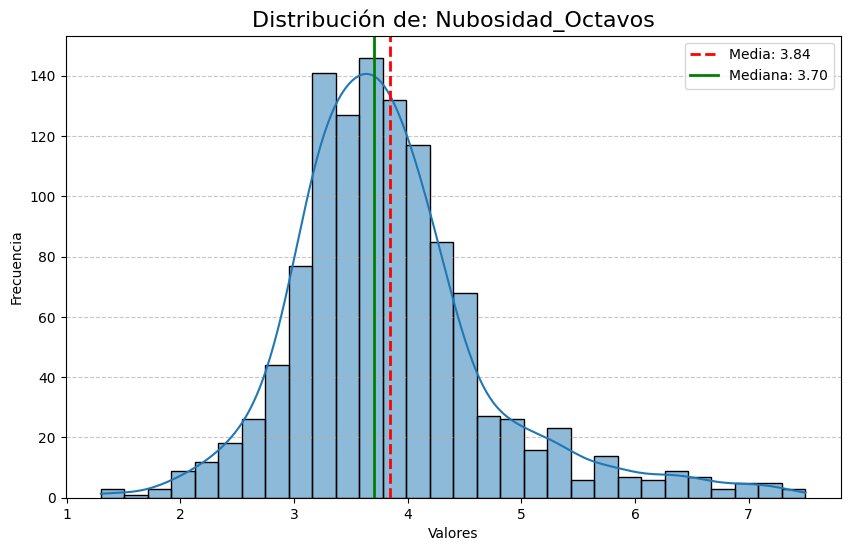

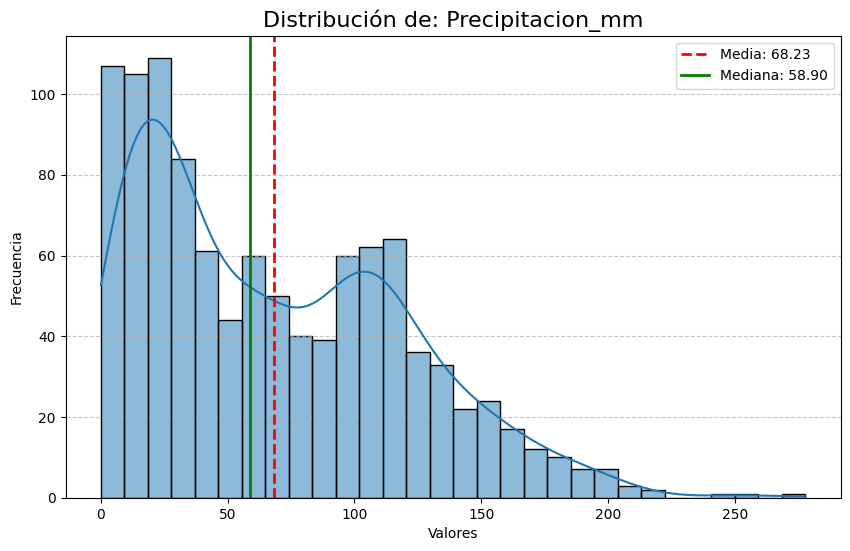

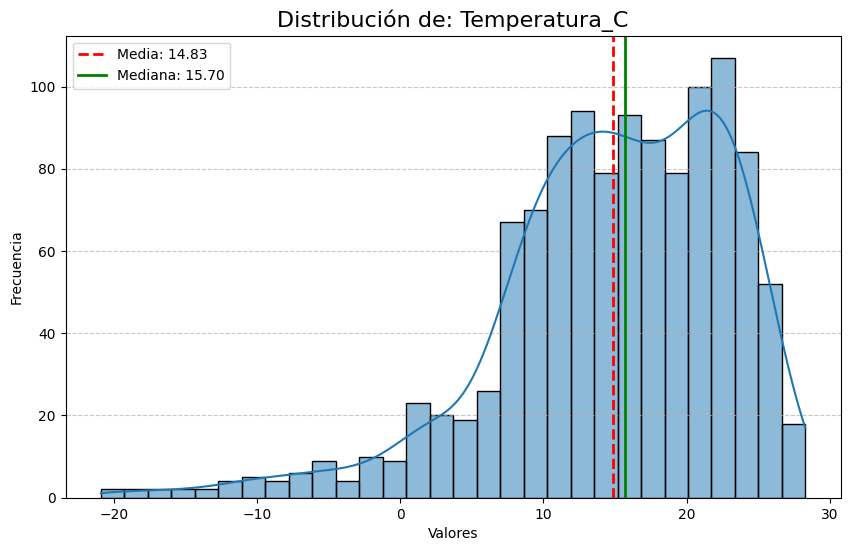

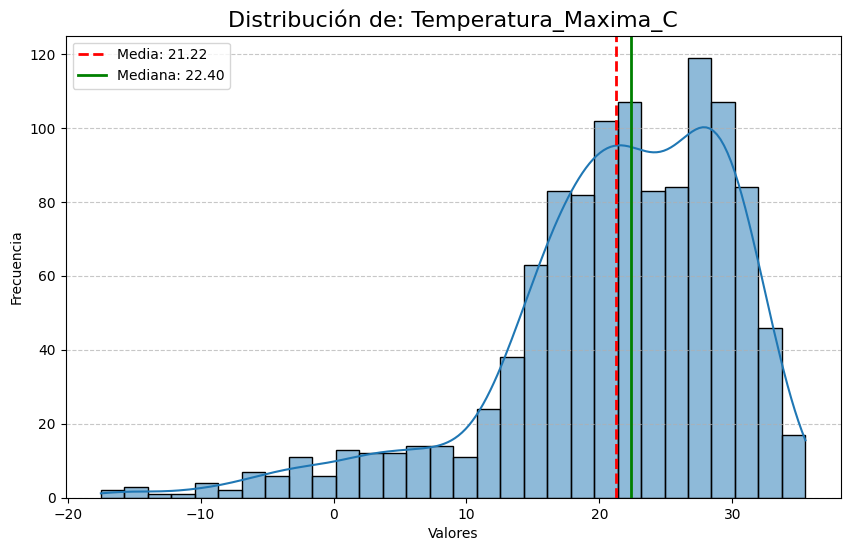

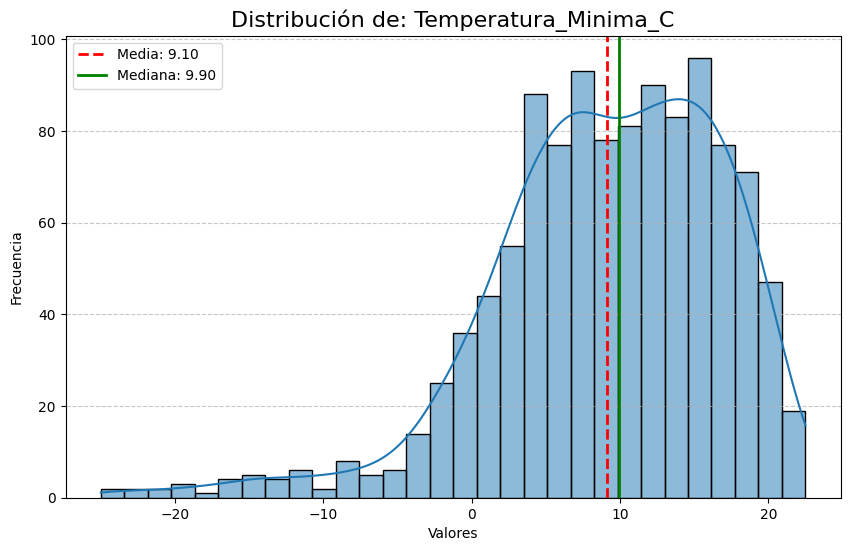

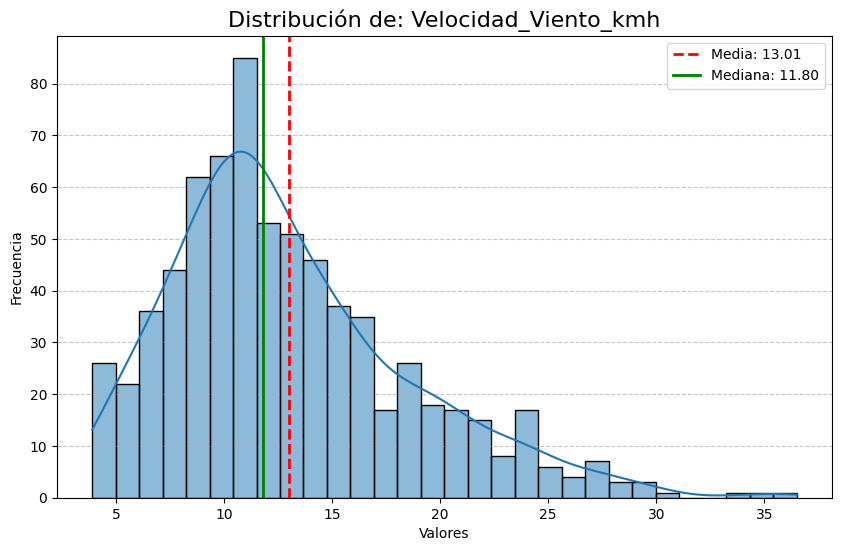

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Histogramas de Distribución por Métrica ---")

for nombre, datos in datos_planos.items():
    # Calcula la media y mediana para marcarlas en el gráfico
    media = datos.mean()
    mediana = datos.median()

    # --- Creación del Gráfico ---
    plt.figure(figsize=(10, 6))
    
    # Crea el histograma con una curva de densidad (KDE)
    sns.histplot(datos, kde=True, bins=30)
    
    # Añade líneas verticales para la media y la mediana
    plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
    plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
    
    # Títulos y leyendas
    plt.title(f'Distribución de: {nombre}', fontsize=16)
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Muestra el gráfico
    plt.show()


--- Box Plots para Detección Visual de Outliers ---


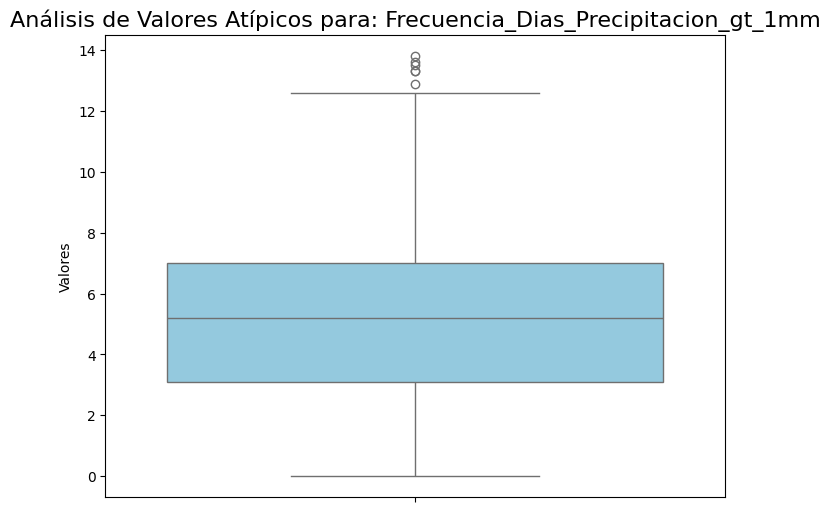

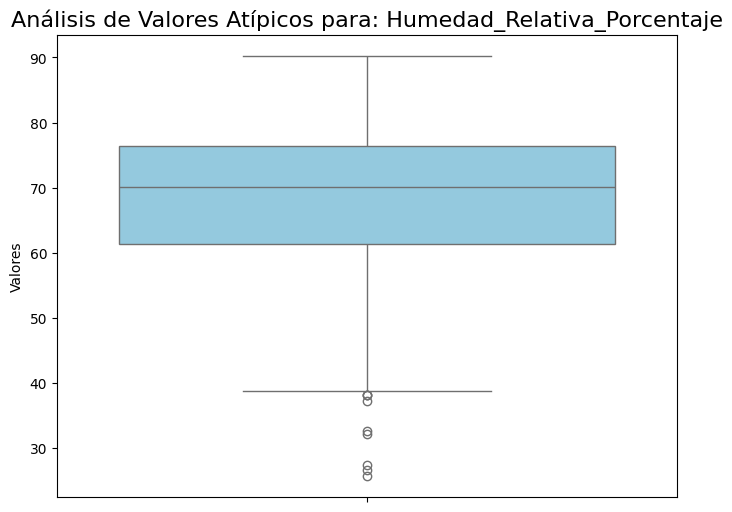

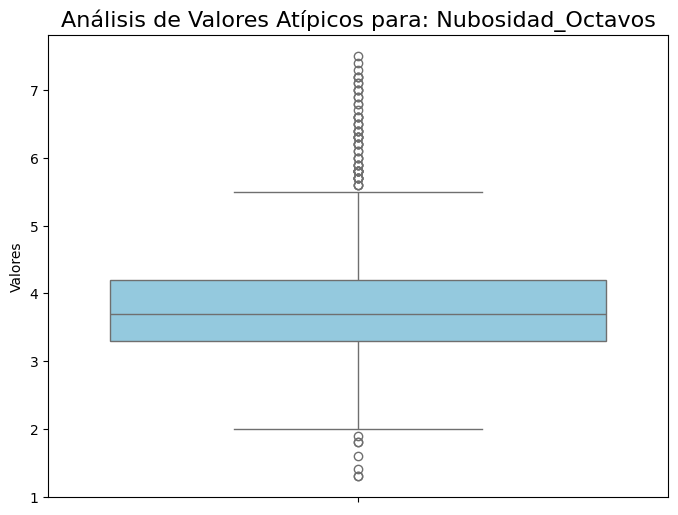

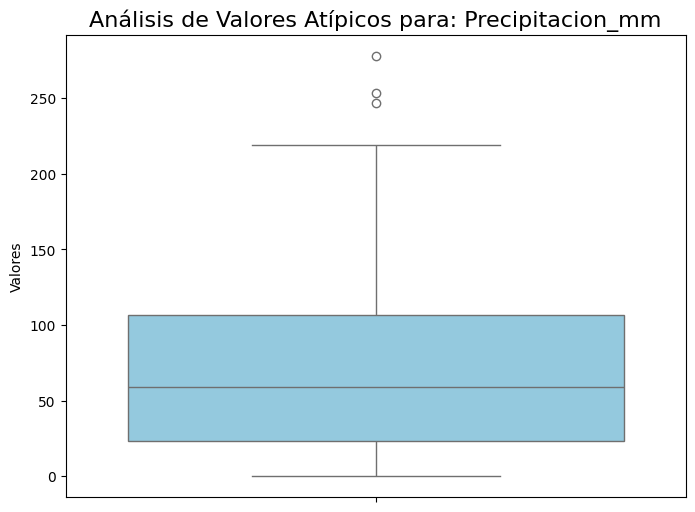

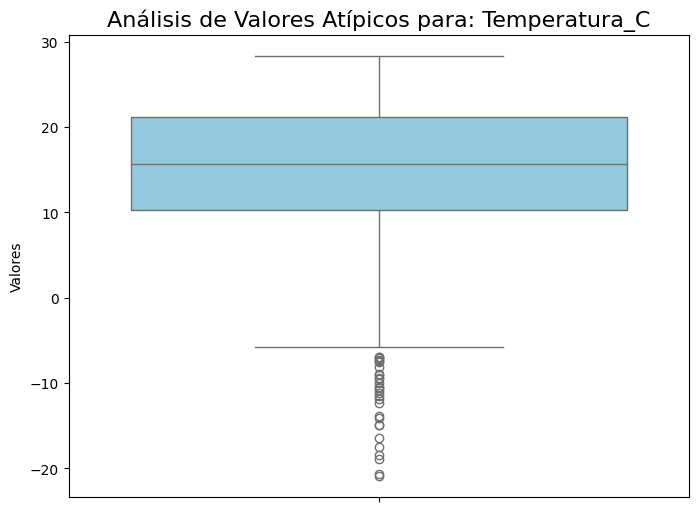

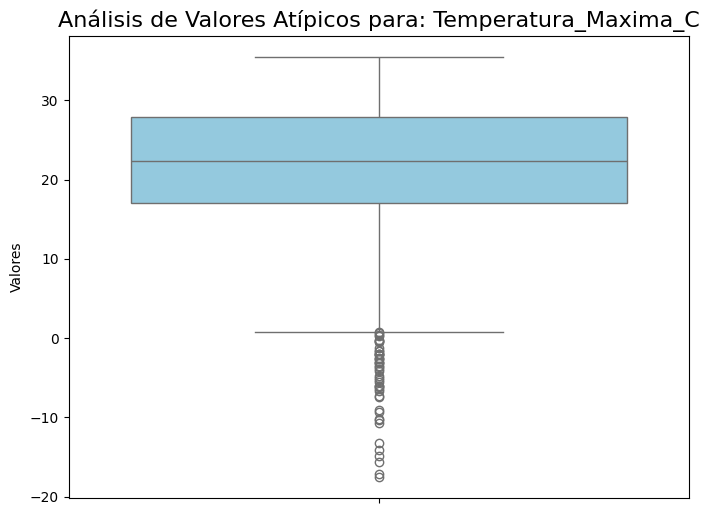

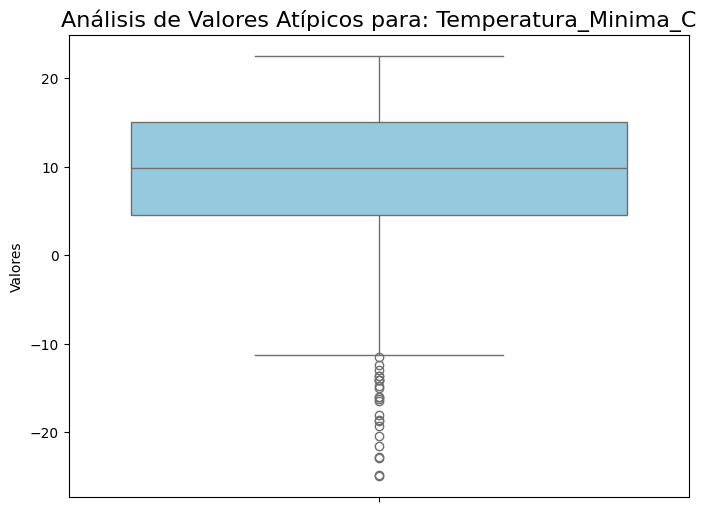

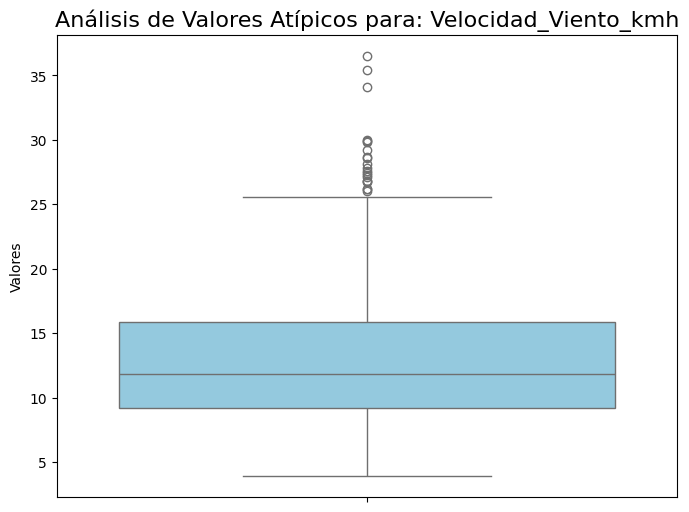

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Box Plots para Detección Visual de Outliers ---")

# Usamos el diccionario 'datos_planos' que creamos en el paso anterior
for nombre, datos in datos_planos.items():
    plt.figure(figsize=(8, 6))
    
    # Crea el diagrama de caja
    sns.boxplot(y=datos, color='skyblue')
    
    # Títulos
    plt.title(f'Análisis de Valores Atípicos para: {nombre}', fontsize=16)
    plt.ylabel('Valores')
    
    # Muestra el gráfico
    plt.show()

In [17]:
print("\n--- Identificación de Outliers con el Método IQR ---")

for nombre, datos in datos_planos.items():
    # 1. Calcular Q1, Q3 y el Rango Intercuartílico (IQR)
    Q1 = datos.quantile(0.25)
    Q3 = datos.quantile(0.75)
    IQR = Q3 - Q1
    
    # 2. Definir los límites para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # 3. Filtrar los datos para encontrar los outliers
    outliers = datos[(datos < limite_inferior) | (datos > limite_superior)]
    
    print(f"\n🔎 Análisis para: {nombre}")
    if not outliers.empty:
        print(f"  Se encontraron {len(outliers)} outliers.")
        # Muestra los 5 outliers más extremos (altos o bajos)
        print("  Algunos valores atípicos encontrados:")
        print(outliers.sort_values(ascending=False).head())
    else:
        print("  No se encontraron outliers con este método.")


--- Identificación de Outliers con el Método IQR ---

🔎 Análisis para: Frecuencia_Dias_Precipitacion_gt_1mm
  Se encontraron 6 outliers.
  Algunos valores atípicos encontrados:
38    13.8
25    13.6
38    13.5
3     13.3
38    13.3
Name: Frecuencia_Dias_Precipitacion_gt_1mm, dtype: float64

🔎 Análisis para: Humedad_Relativa_Porcentaje
  Se encontraron 9 outliers.
  Algunos valores atípicos encontrados:
77    38.2
77    38.1
53    38.1
53    37.2
41    32.6
Name: Humedad_Relativa_Porcentaje, dtype: float64

🔎 Análisis para: Nubosidad_Octavos
  Se encontraron 69 outliers.
  Algunos valores atípicos encontrados:
8    7.5
8    7.4
8    7.3
8    7.2
8    7.2
Name: Nubosidad_Octavos, dtype: float64

🔎 Análisis para: Precipitacion_mm
  Se encontraron 3 outliers.
  Algunos valores atípicos encontrados:
10    277.9
64    253.4
35    247.0
Name: Precipitacion_mm, dtype: float64

🔎 Análisis para: Temperatura_C
  Se encontraron 29 outliers.
  Algunos valores atípicos encontrados:
6   -6.9
4   -7.

In [18]:
import numpy as np

print("\n--- Identificación de Outliers con el Método Z-Score ---")

# Definimos el umbral del Z-score
umbral_z = 3

for nombre, datos in datos_planos.items():
    # 1. Calcular la media y la desviación estándar
    media = datos.mean()
    desv_estandar = datos.std()
    
    # 2. Calcular el Z-score para cada punto
    z_scores = (datos - media) / desv_estandar
    
    # 3. Filtrar los datos para encontrar los outliers
    outliers = datos[np.abs(z_scores) > umbral_z]
    
    print(f"\n🔎 Análisis para: {nombre}")
    if not outliers.empty:
        print(f"  Se encontraron {len(outliers)} outliers (Z-score > {umbral_z}).")
        # Muestra los outliers encontrados
        print("  Valores atípicos encontrados:")
        print(outliers.sort_values(ascending=False).head())
    else:
        print("  No se encontraron outliers con este método.")


--- Identificación de Outliers con el Método Z-Score ---

🔎 Análisis para: Frecuencia_Dias_Precipitacion_gt_1mm
  Se encontraron 6 outliers (Z-score > 3).
  Valores atípicos encontrados:
38    13.8
25    13.6
38    13.5
3     13.3
38    13.3
Name: Frecuencia_Dias_Precipitacion_gt_1mm, dtype: float64

🔎 Análisis para: Humedad_Relativa_Porcentaje
  Se encontraron 5 outliers (Z-score > 3).
  Valores atípicos encontrados:
41    32.6
41    32.1
41    27.4
41    26.7
41    25.7
Name: Humedad_Relativa_Porcentaje, dtype: float64

🔎 Análisis para: Nubosidad_Octavos
  Se encontraron 20 outliers (Z-score > 3).
  Valores atípicos encontrados:
8    7.5
8    7.4
8    7.3
8    7.2
8    7.2
Name: Nubosidad_Octavos, dtype: float64

🔎 Análisis para: Precipitacion_mm
  Se encontraron 3 outliers (Z-score > 3).
  Valores atípicos encontrados:
10    277.9
64    253.4
35    247.0
Name: Precipitacion_mm, dtype: float64

🔎 Análisis para: Temperatura_C
  Se encontraron 18 outliers (Z-score > 3).
  Valores atíp